# <b>데이터 전처리</b> Preprocessing

## <b>0.0 라이브러리</b>

### <b>0.1 사용 툴 / 라이브러리</b> (추후 정리)


|구분|내용|설명|
|---|---|---|
|Lib|pandas|.|
|Lib|numpy|.|
|Lib|konlpy|.|
|Lib|pykospacing|.|
|Lib|hanspell|.|
|Lib|tensorflow|.|
|Lib|nltk|.|
|Lib|collections|.|
|Lib|matplotlib|.|
|Lib|seaborn|.|
|Lib|os|.|
|Lib|tqdm|.|
|Lib|eunjeon|토큰화|
|Tool|Tableau|.|

In [31]:
# 범용 라이브러리
import pandas as pd     # DataFrame, Series 및 데이터 분석
import numpy as np      # Array 및 
from tqdm import tqdm   # 진행상황 Progress Bar를 위한 tqdm library
import re               # Regular Expression 사용
import pickle           # 토큰화된 단어목록의 인덱스를 저장, 불러오기 위해 사용
from sklearn.model_selection import train_test_split

# 토크나이징, 인코딩 관련 라이브러리
from eunjeon import Mecab           # Mecab 형태소 분석기의 한국어+윈도우용 버전인 은전한닢 프로젝트
from collections import Counter     
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 그래프 관련 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import platform

# 한글 폰트 설정
if (platform.system() == 'Windows'):
    plt.rc('font', family='Malgun Gothic')
else:
    plt.rc('font', family='AppleGothic')

# 음수(-)가 깨지는 현상 방지
plt.rcParams['axes.unicode_minus'] = False 

## <b>1.0 데이터 불러오기</b>

In [32]:
# 실습용자료 불러와 csv로 저장

# train = pd.read_table("./data/1. 실습용자료.txt", encoding='CP949', sep='|') # 실습용자료의 구분자 '|'
# train.to_csv('./data/train.csv', index=False)


#  불러와 csv로 저장

# test = pd.read_table("./data/2. 모델개발용자료.txt", encoding='CP949', sep='|') # 모델개발용자료의 구분자 '|'
# test.to_csv('./data/test.csv', index=False)

# 데이터 불러오기

train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')


In [33]:
# 한국표준산업분류 딕셔너리 생성

cat_dic = pd.read_excel('./data/한국표준산업분류(10차)_국문.xlsx').iloc[2:,0:6]
cat_dic.rename(columns={'개정 분류체계(제10차 기준)':'대분류', 'Unnamed: 1':'대분류명', 
                        'Unnamed: 2': '중분류', 'Unnamed: 3': '중분류명',
                        'Unnamed: 4': '소분류', 'Unnamed: 5': '소분류명'}, inplace=True)

digit_1_df = cat_dic[['대분류', '대분류명']].dropna().reset_index(drop=True) # 대분류 'A' ~ 'U'
digit_2_df = cat_dic[['중분류', '중분류명']].dropna().reset_index(drop=True) # 중분류 1 ~ 99
digit_3_df = cat_dic[['소분류', '소분류명']].dropna().reset_index(drop=True) # 소분류 11 ~ 990

digit_1_dict = {} # 대분류 딕셔너리
digit_2_dict = {} # 중분류 딕셔너리
digit_3_dict = {} # 소분류 딕셔너리

for i in tqdm(range(len(digit_1_df)+len(digit_2_df)+len(digit_3_df))):
    if i < len(digit_1_df):
        digit_1_dict[digit_1_df.iloc[i]['대분류']] = digit_1_df.iloc[i]['대분류명']
    if i < len(digit_2_df):
        digit_2_dict[int(digit_2_df.iloc[i]['중분류'])] = digit_2_df.iloc[i]['중분류명']
    if i < len(digit_3_df):
        digit_3_dict[int(digit_3_df.iloc[i]['소분류'])] = digit_3_df.iloc[i]['소분류명']


# 생성된 딕셔너리 피클로 저장

with open('./data/dictionary/digit_1_dict.pickle', 'wb') as handle:
    pickle.dump(digit_1_dict, handle)

with open('./data/dictionary/digit_2_dict.pickle', 'wb') as handle:
    pickle.dump(digit_2_dict, handle)

with open('./data/dictionary/digit_3_dict.pickle', 'wb') as handle:
    pickle.dump(digit_3_dict, handle)

100%|██████████| 330/330 [00:00<00:00, 10301.43it/s]


In [34]:
print(digit_1_dict, digit_2_dict, digit_3_dict)

{'A': '농업, 임업 및 어업(01~03)', 'B': '광업(05~08)', 'C': '제조업(10~34)', 'D': '전기, 가스, 증기 및 공기 조절 공급업(35)', 'E': '수도, 하수 및 폐기물 처리, 원료 재생업(36~39)', 'F': '건설업(41~42)', 'G': '도매 및 소매업(45~47)', 'H': '운수 및 창고업(49~52)', 'I': '숙박 및 음식점업(55~56)', 'J': '정보통신업(58~63)', 'K': '금융 및 보험업(64~66)', 'L': '부동산업(68)', 'M': '전문, 과학 및 기술 서비스업(70~73)', 'N': '사업시설 관리, 사업 지원 및 임대 서비스업(74~76)', 'O': '공공 행정, 국방 및 사회보장 행정(84)', 'P': '교육 서비스업(85)', 'Q': '보건업 및 사회복지 서비스업(86~87)', 'R': '예술, 스포츠 및 여가관련 서비스업(90~91)', 'S': '협회 및 단체, 수리 및 기타 개인 서비스업(94~96)', 'T': '가구 내 고용활동 및 달리 분류되지 않은 자가 소비 생산활동(97~98)', 'U': '국제 및 외국기관(99)'} {1: '농업', 2: '임업', 3: '어업', 5: '석탄, 원유 및 천연가스 광업', 6: '금속 광업', 7: '비금속광물 광업; 연료용 제외', 8: '광업 지원 서비스업', 10: '식료품 제조업', 11: '음료 제조업', 12: '담배 제조업', 13: '섬유제품 제조업; 의복 제외', 14: '의복, 의복 액세서리 및 모피제품 제조업', 15: '가죽, 가방 및 신발 제조업', 16: '목재 및 나무제품 제조업; 가구 제외', 17: '펄프, 종이 및 종이제품 제조업', 18: '인쇄 및 기록매체 복제업', 19: '코크스, 연탄 및 석유정제품 제조업', 20: '화학 물질 및 화학제품 제조업; 의약품 제외', 21: '의료용 물질 및 의약품 제조업', 22: '고무 및 플라스틱제품 제조업', 23: 

## <b>2.0 데이터 탐색</b>

In [20]:
# head()로 첫 5줄 데이터 형태 및 컬럼 탐색

print(train.head(), '\n')

print(test.head())

# 일련번호(AI_id), 산업대분류(digit_1), 산업중분류(digit_2), 산업소분류(digit_3), 
# 사업 대상(text_obj), 사업 방법(text_mthd), 사업 취급품목(text_deal)

        AI_id digit_1  digit_2  digit_3    text_obj    text_mthd text_deal
0  id_0000001       S       95      952       카센터에서      자동차부분정비   타이어오일교환
1  id_0000002       G       47      472       상점내에서    일반인을 대상으로   채소.과일판매
2  id_0000003       G       46      467  절단하여사업체에도매    공업용고무를가지고    합성고무도매
3  id_0000004       G       47      475       영업점에서      일반소비자에게    열쇠잠금장치
4  id_0000005       Q       87      872        어린이집  보호자의 위탁을 받아   취학전아동보육 

       AI_id  digit_1  digit_2  digit_3  text_obj  text_mthd text_deal
0  id_000001      NaN      NaN      NaN   치킨전문점에서   고객의주문에의해      치킨판매
1  id_000002      NaN      NaN      NaN      산업공구  다른 소매업자에게    철물 수공구
2  id_000003      NaN      NaN      NaN       절에서   신도을 대상으로    불교단체운영
3  id_000004      NaN      NaN      NaN     영업장에서      고객요구로     자동차튜닝
4  id_000005      NaN      NaN      NaN  실내포장마차에서  접객시설을 갖추고   소주,맥주제공


In [21]:
# info()

print(train.info(), '\n') # 전체 100만 건, text 컬럼들에 널값 존재, digit_2와 3 컬럼은 정수형 타입

print(test.info()) # 전체 100만 건, text 컬럼들에 널값 존재, digit(label) 컬럼들은 널값

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   AI_id      1000000 non-null  object
 1   digit_1    1000000 non-null  object
 2   digit_2    1000000 non-null  int64 
 3   digit_3    1000000 non-null  int64 
 4   text_obj   983323 non-null   object
 5   text_mthd  956381 non-null   object
 6   text_deal  932348 non-null   object
dtypes: int64(2), object(5)
memory usage: 53.4+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   AI_id      100000 non-null  object 
 1   digit_1    0 non-null       float64
 2   digit_2    0 non-null       float64
 3   digit_3    0 non-null       float64
 4   text_obj   98189 non-null   object 
 5   text_mthd  97032 non-null   object 
 6   text_deal  93839 non

### <b>2.1 시각적 EDA</b>

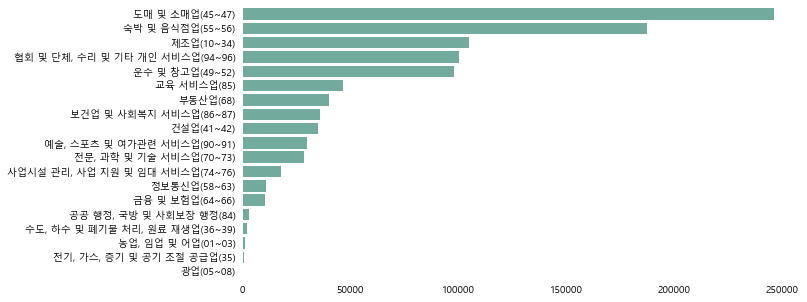

In [94]:
# 대분류 분포 그래프

digit_1_count = train.groupby(['digit_1'], as_index=False)['AI_id'].count()
digit_1_count.replace(digit_1_dict, inplace=True)

# Set the figure size
plot1 = plt.figure(figsize=(10, 5))

# plot a bar chart
sns.barplot(
    x = 'AI_id', y = 'digit_1',
    data = digit_1_count,
    estimator=sum, 
    ci=None, 
    order = list(digit_1_count.sort_values('AI_id', ascending=False)['digit_1']),
    color='#69b3a2');

# Hide spines and ticks
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.tick_params(bottom=False)
plt.tick_params(left=False)
plt.xlabel("")
plt.ylabel("")

plt.show()

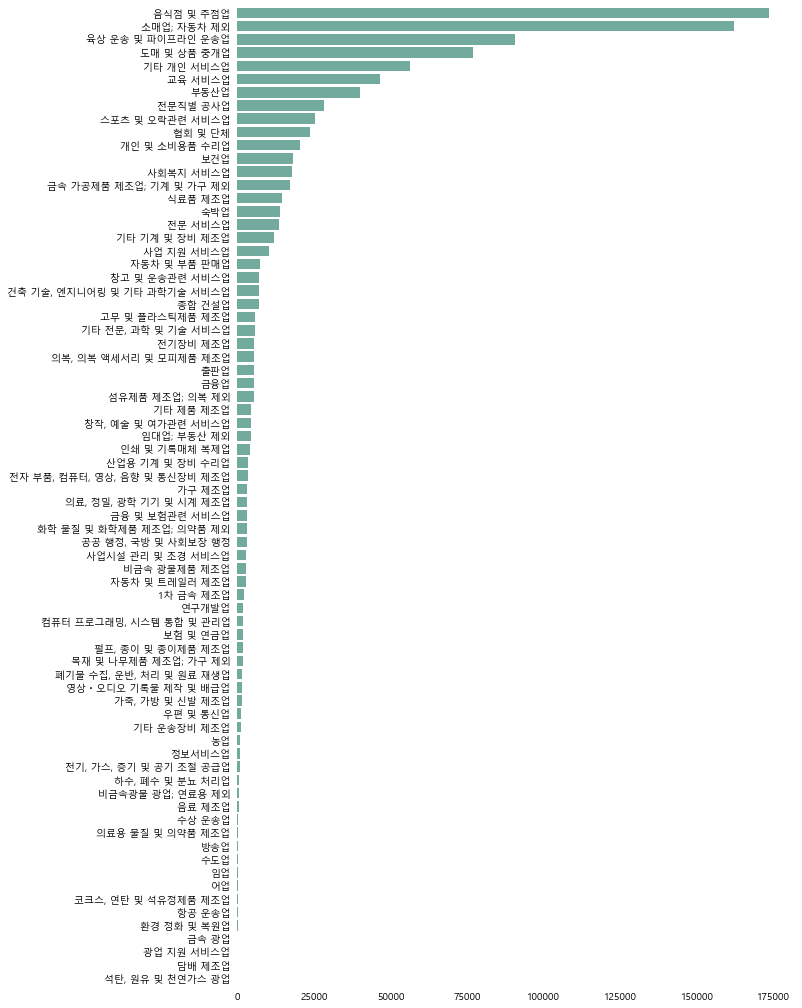

In [92]:
# 중분류 분포 그래프

digit_2_count = train.groupby(['digit_2'], as_index=False)['AI_id'].count()
digit_2_count['DDdigit_2'] = digit_2_count['digit_2'].replace(digit_2_dict)

# Set the figure size
plt.figure(figsize=(10, 18))

# plot a bar chart
sns.barplot(
    x = 'AI_id', y = 'digit_2',
    data = digit_2_count,
    estimator=sum, 
    ci=None, 
    order = list(digit_2_count.sort_values('AI_id', ascending=False)['digit_2']),
    color='#69b3a2');

# Hide spines and ticks
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.tick_params(bottom=False)
plt.tick_params(left=False)
plt.xlabel("")
plt.ylabel("")


plt.show()

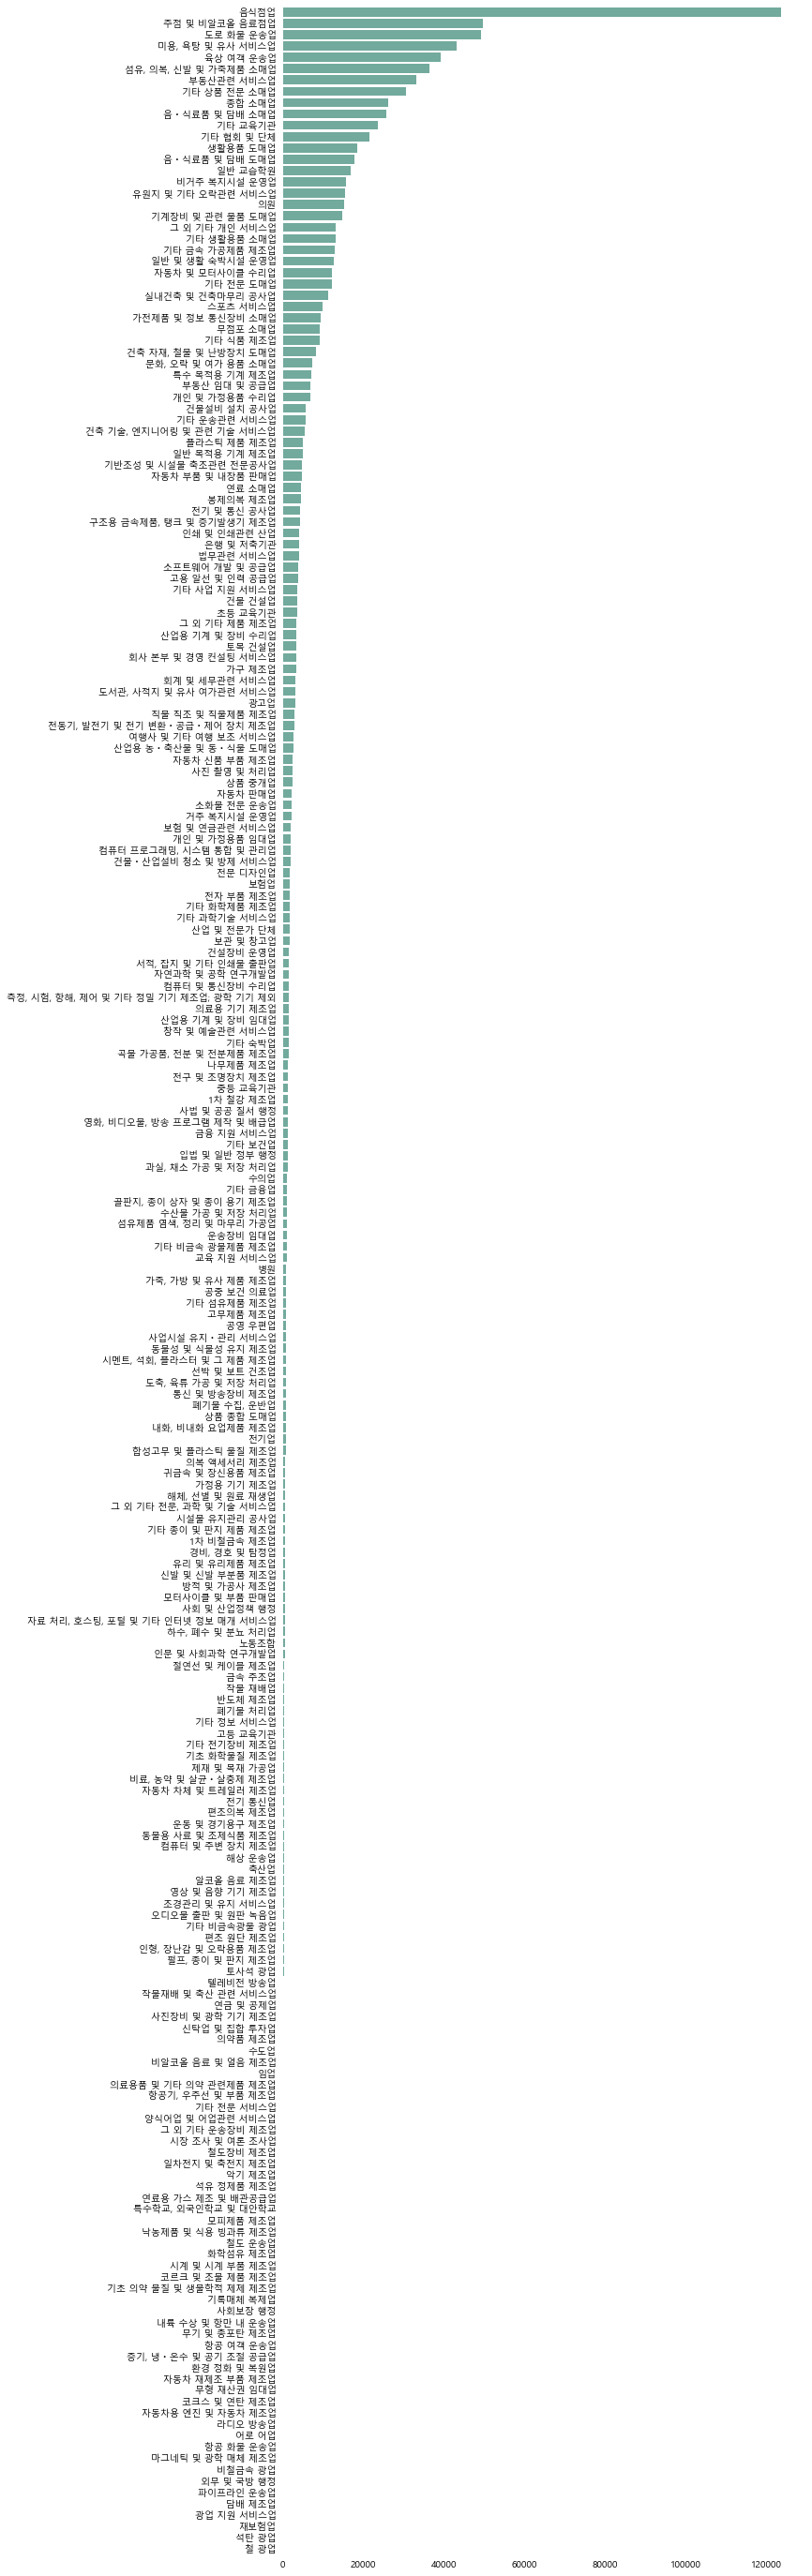

In [98]:
# 소분류 분포 그래프

digit_3_count = train.groupby(['digit_3'], as_index=False)['AI_id'].count()
digit_3_count['digit_3'] = digit_3_count['digit_3'].replace(digit_3_dict)

# Set the figure size
plt.figure(figsize=(10, 50))

# plot a bar chart
sns.barplot(
    x = 'AI_id', y = 'digit_3',
    data = digit_3_count,
    estimator=sum, 
    ci=None, 
    order = list(digit_3_count.sort_values('AI_id', ascending=False)['digit_3']),
    color='#69b3a2');

# Hide spines and ticks
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.tick_params(bottom=False)
plt.tick_params(left=False)
plt.xlabel("")
plt.ylabel("")

plt.show()

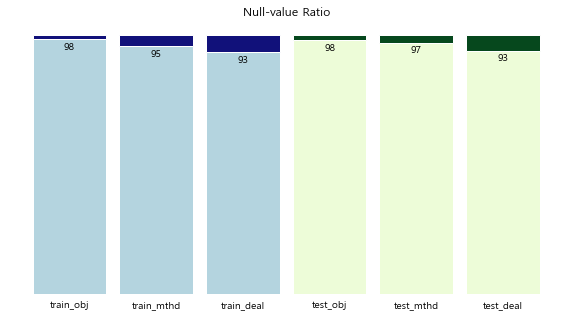

In [68]:
# 널값 비율 그래프

# Data
r1 , r2 = [0,1,2], [3,4,5] # for X row

train_data = {'notnull': [train['text_obj'].count(), train['text_mthd'].count(), train['text_deal'].count()],
            'isnull': [train['text_obj'].isnull().sum(), train['text_mthd'].isnull().sum(), train['text_deal'].isnull().sum()]}
test_data = {'notnull': [test['text_obj'].count(), test['text_mthd'].count(), test['text_deal'].count()],
            'isnull': [test['text_obj'].isnull().sum(), test['text_mthd'].isnull().sum(), test['text_deal'].isnull().sum()]}

train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)
 
# From raw value to percentage
train_totals = [i+j for i,j in zip(train_data['notnull'], train_data['isnull'])] # for train
train_notnull = [i / j * 100 for i,j in zip(train_data['notnull'], train_totals)]
train_isnull = [i / j * 100 for i,j in zip(train_data['isnull'], train_totals)]

test_totals = [i+j for i,j in zip(test_data['notnull'], test_data['isnull'])] # for test
test_notnull = [i / j * 100 for i,j in zip(test_data['notnull'], test_totals)]
test_isnull = [i / j * 100 for i,j in zip(test_data['isnull'], test_totals)]
 
# plot
plt.figure(figsize=(10, 5))
barWidth = 0.85

# Create train bars
plot1 = plt.bar(r1, train_notnull, color='#B4D4DF', edgecolor='white', width=barWidth)
plt.bar(r1, train_isnull, bottom=train_notnull, color='#11117A', edgecolor='white', width=barWidth)

# Create text bars
plot2 = plt.bar(r2, test_notnull, color='#EDFCD8', edgecolor='white', width=barWidth)
plt.bar(r2, test_isnull, bottom=test_notnull, color='#06481D', edgecolor='white', width=barWidth)

# Custom x axis
names = ('train_obj','train_mthd','train_deal','test_obj','test_mthd', 'test_deal')
plt.xticks(r1+r2, names)

for value in plot1:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,
             0.95*height,'%d' % int(height), ha='center', va='bottom')

for value in plot2:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,
             0.95*height,'%d' % int(height), ha='center', va='bottom')

# Hide spines and ticks
ax = plt.gca()
ax.axes.yaxis.set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.tick_params(bottom=False)

# Title
plt.title("Null-value Ratio")

# Show graphic
plt.show()

## <b>3.0 데이터 정제</b>

### <b>~~구두점, 오타 제거~~</b>

In [35]:
# 구두점, 오타(ㅋ, ㅡ 등 한글자) 제거

for col in tqdm(train[['text_obj', 'text_mthd', 'text_deal']].columns):
    train[col] = train[col].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-z ]',' ', regex=True).str.replace('[* , .]', ' ', regex=True)
    test[col] = test[col].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-z ]','', regex=True).str.replace('[* , .]', ' ', regex=True)

100%|██████████| 3/3 [00:03<00:00,  1.33s/it]


### <b>결측치 처리</b>

In [36]:
# 결측값 탐색

condition1 = train['text_obj'].isnull() == True
condition2 = train['text_mthd'].isnull() == True
condition3 = train['text_deal'].isnull() == True

print("세 컬럼 모두 널 값인 경우: ", len(train[condition1&condition2&condition3])) # 세 컬럼 모두 Null 값인 로우는 없음.
print("obj 컬럼 널 값인 경우: ", len(train[condition1]))
print("mthd 컬럼 널 값인 경우: ", len(train[condition2]))
print("deal 컬럼 널 값인 경우: ", len(train[condition3]))


# 결측치를 ""로 대치 

train.fillna("",inplace=True)
test.fillna("", inplace=True)

세 컬럼 모두 널 값인 경우:  0
obj 컬럼 널 값인 경우:  16677
mthd 컬럼 널 값인 경우:  43619
deal 컬럼 널 값인 경우:  67652


## <b>4.0 토큰화</b>

In [37]:
# 작성해둔 한국어 불용어 사전 불러오기

stopwords = pd.read_csv("./data/stopwords/stopwords.csv", encoding='CP949')
stopwords = stopwords['stopwords']
print(stopwords, len(stopwords))

0        고
1        업
2        아
3        휴
4      아이구
      ... 
661      원
662      잘
663     통하
664     소리
665      놓
Name: stopwords, Length: 666, dtype: object 666


### Mecab

In [38]:
# train 데이터 토크나이징

mecab_train_text_obj = []
mecab_train_text_mthd = []
mecab_train_text_deal = []

mecab = Mecab()

for sentence in tqdm(train['text_obj']): # 진행상황 Progress Bar를 위한 tqdm library
    tokenized_sentence = mecab.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in list(stopwords)] # 불용어 제거
    mecab_train_text_obj.append(stopwords_removed_sentence)

for sentence in tqdm(train['text_mthd']):
    tokenized_sentence = mecab.morphs(sentence) 
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in list(stopwords)] # 불용어 제거
    mecab_train_text_mthd.append(stopwords_removed_sentence)

for sentence in tqdm(train['text_deal']):
    tokenized_sentence = mecab.morphs(sentence) 
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in list(stopwords)] # 불용어 제거
    mecab_train_text_deal.append(stopwords_removed_sentence)

100%|██████████| 1000000/1000000 [02:20<00:00, 7124.10it/s]


In [39]:
# test 데이터 토크나이징

mecab_test_text_obj = []
mecab_test_text_mthd = []
mecab_test_text_deal = []

mecab = Mecab()

for sentence in tqdm(test['text_obj']): # 진행상황 Progress Bar를 위한 tqdm library
    tokenized_sentence = mecab.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in list(stopwords)] # 불용어 제거
    mecab_test_text_obj.append(stopwords_removed_sentence)

for sentence in tqdm(test['text_mthd']):
    tokenized_sentence = mecab.morphs(sentence)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in list(stopwords)] # 불용어 제거
    mecab_test_text_mthd.append(stopwords_removed_sentence)

for sentence in tqdm(test['text_deal']): 
    tokenized_sentence = mecab.morphs(sentence) 
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in list(stopwords)] # 불용어 제거
    mecab_test_text_deal.append(stopwords_removed_sentence)

100%|██████████| 100000/100000 [00:14<00:00, 6696.35it/s]


In [40]:
# 토큰화된 결과 합쳐 text 컬럼으로 생성

# train 데이터
train['text'] = mecab_train_text_obj
train['text'] = train['text'] + mecab_train_text_mthd
train['text'] = train['text'] + mecab_train_text_deal

# test 데이터
test['text'] = mecab_test_text_obj
test['text'] = test['text'] + mecab_test_text_mthd
test['text'] = test['text'] + mecab_test_text_deal

C:\Users\Huitaek\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return op(a, b)


In [41]:
train.head()

,AI_id,digit_1,digit_2,digit_3,text_obj,text_mthd,text_deal,text
0,id_0000001,S,95,952,카센터에서,자동차부분정비,타이어오일교환,"[카센터, 자동차, 부분, 정비, 타이어, 교환]"
1,id_0000002,G,47,472,상점내에서,일반인을 대상으로,채소 과일판매,"[상점, 일반인, 대상, 채소, 과일, 판매]"
2,id_0000003,G,46,467,절단하여사업체에도매,공업용고무를가지고,합성고무도매,"[절단, 사업체, 도매, 공업, 고무, 합성, 고무, 도매]"
3,id_0000004,G,47,475,영업점에서,일반소비자에게,열쇠잠금장치,"[영업, 일반, 소비자, 열쇠, 잠금장치]"
4,id_0000005,Q,87,872,어린이집,보호자의 위탁을 받아,취학전아동보육,"[어린이집, 보호자, 위탁, 취학전, 아동, 보육]"


In [42]:
test.head()

,AI_id,digit_1,digit_2,digit_3,text_obj,text_mthd,text_deal,text
0,id_000001,,,,치킨전문점에서,고객의주문에의해,치킨판매,"[치킨, 전문점, 고객, 주문, 치킨, 판매]"
1,id_000002,,,,산업공구,다른 소매업자에게,철물 수공구,"[산업, 공구, 소매업자, 철물, 수공구]"
2,id_000003,,,,절에서,신도을 대상으로,불교단체운영,"[절, 신도, 대상, 불교, 단체, 운영]"
3,id_000004,,,,영업장에서,고객요구로,자동차튜닝,"[영업장, 고객, 요구, 자동차, 튜닝]"
4,id_000005,,,,실내포장마차에서,접객시설을 갖추고,소주맥주제공,"[실내, 포장마차, 접객, 시설, 갖추, 소주, 맥주, 제공]"


In [43]:
# mecab 형태소 분석기로 토큰화된 데이터 사용하기 편하도록 csv 파일로 저장

X_train = train.drop(columns=['text_obj', 'text_mthd', 'text_deal'])
X_train.to_csv('./data/mecab/tokenized_train.csv', encoding='CP949', index=False)

X_test = test.drop(columns=['text_obj', 'text_mthd', 'text_deal'])
X_test.to_csv('./data/mecab/tokenized_test.csv', encoding='CP949', index=False)

### <b>토큰화 결과 EDA</b>

In [44]:
# 대분류 빈도수 카운트

for i in list(X_train['digit_1'].unique()):
    print('<',digit_1_dict[i],'>')
    cat_words = np.hstack(X_train[X_train['digit_1'] == i]['text'].values)
    cat_words_count = Counter(cat_words)
    print(cat_words_count.most_common(20), '\n')

< 협회 및 단체, 수리 및 기타 개인 서비스업(94~96) >
[('대상', 41820), ('서비스', 40015), ('고객', 31272), ('종교', 25880), ('일반', 20393), ('미용실', 15420), ('염색', 15146), ('수리', 14152), ('활동', 14064), ('파마', 13729), ('교회', 13073), ('사업장', 11730), ('기독교', 10748), ('자동차', 10104), ('계통', 9532), ('일반인', 9136), ('인', 9084), ('컷트', 8129), ('발미', 7523), ('제공', 7383)] 

< 도매 및 소매업(45~47) >
[('일반', 98594), ('소비자', 78369), ('소매', 74629), ('대상', 70957), ('매장', 65071), ('판매', 61918), ('사업장', 49554), ('도매', 47526), ('고객', 22324), ('소매업자', 22128), ('의류', 19612), ('일반인', 19308), ('인', 16301), ('가게', 14843), ('용품', 13050), ('산업', 12483), ('사용자', 11340), ('영업장', 10905), ('여성', 10643), ('편의점', 10251)] 

< 보건업 및 사회복지 서비스업(86~87) >
[('환자', 15135), ('외래', 12553), ('진료', 12085), ('서비스', 12083), ('위주', 10732), ('의원', 9952), ('대상', 9215), ('어린이', 8281), ('보육', 7569), ('치과', 7141), ('유아', 5957), ('취학전', 5536), ('노인', 5502), ('복지', 4969), ('요양', 4557), ('위탁', 4317), ('아동', 4310), ('보호자', 3721), ('일반', 3698), ('치료', 3276)] 

< 제조업(10~34) 

In [45]:
# 중분류 빈도수 카운트

for i in list(X_train['digit_2'].unique()):
    print('<',digit_2_dict[i],'>')
    cat_words = np.hstack(X_train[X_train['digit_2'] == i]['text'].values)
    cat_words_count = Counter(cat_words)
    print(cat_words_count.most_common(20), '\n')

< 개인 및 소비용품 수리업 >
[('수리', 14118), ('자동차', 10067), ('고객', 8874), ('대상', 6871), ('수선', 5766), ('서비스', 4340), ('사업장', 4213), ('카센타', 3995), ('부분', 3736), ('특정', 3318), ('일반', 3216), ('전문', 3176), ('정비', 2934), ('경정비', 2777), ('요청', 2727), ('옷', 2193), ('타이어', 1986), ('세차', 1850), ('일반인', 1638), ('내장', 1440)] 

< 소매업; 자동차 제외 >
[('일반', 91097), ('소비자', 74892), ('소매', 70691), ('대상', 55496), ('매장', 53288), ('판매', 49386), ('사업장', 19400), ('일반인', 17817), ('고객', 16740), ('의류', 16514), ('인', 14883), ('가게', 13006), ('편의점', 10229), ('음식료품', 9677), ('여성', 9499), ('용품', 8836), ('위주', 8053), ('식료품', 7267), ('체인', 6674), ('계약', 6599)] 

< 도매 및 상품 중개업 >
[('도매', 46025), ('사업장', 27742), ('소매업자', 21584), ('대상', 12322), ('산업', 12003), ('사용자', 10875), ('매장', 10270), ('판매', 9428), ('일반', 5033), ('영업장', 4658), ('도소매', 3588), ('상가', 3491), ('고객', 3488), ('용품', 3405), ('의류', 3096), ('수집', 3079), ('업체', 2996), ('기계', 2956), ('부품', 2912), ('고철', 2887)] 

< 사회복지 서비스업 >
[('어린이', 8240), ('보육', 7569), ('유아', 5934), ('취

In [24]:
# 소분류 빈도수 카운트

for i in list(X_train['digit_3'].unique()):
    print('<',digit_3_dict[i],'>')
    cat_words = np.hstack(X_train[X_train['digit_3'] == i]['text'].values)
    cat_words_count = Counter(cat_words)
    print(cat_words_count.most_common(20), '\n')

< 자동차 및 모터사이클 수리업 >
[('자동차', 10067), ('수리', 9289), ('고객', 5052), ('대상', 4688), ('카센타', 3995), ('부분', 3663), ('특정', 3260), ('정비', 2927), ('전문', 2875), ('서비스', 2823), ('경정비', 2777), ('사업장', 2184), ('타이어', 1983), ('세차', 1850), ('일반', 1573), ('내장', 1437), ('차량', 1301), ('만', 1280), ('카센터', 1139), ('광택', 934)] 

< 음ㆍ식료품 및 담배 소매업 >
[('일반', 16138), ('소비자', 14023), ('소매', 11326), ('대상', 9116), ('판매', 8405), ('매장', 6058), ('가게', 4453), ('사업장', 3422), ('돼지고기', 2871), ('일반인', 2786), ('인', 2626), ('정육점', 2471), ('소고기', 2258), ('고객', 2211), ('과일', 2067), ('반찬', 1876), ('식품', 1840), ('수산물', 1668), ('채소', 1536), ('건강', 1426)] 

< 기타 전문 도매업 >
[('도매', 5933), ('사업장', 4188), ('수집', 3040), ('고철', 2878), ('판매', 2630), ('산업', 2289), ('사용자', 2040), ('대상', 1511), ('고물상', 1473), ('소매업자', 1408), ('비철', 1347), ('재생', 1204), ('매장', 1107), ('농약', 929), ('원단', 882), ('금속', 815), ('고물', 804), ('비료', 794), ('폐지', 730), ('재', 632)] 

< 기타 생활용품 소매업 >
[('일반', 8025), ('소매', 6697), ('소비자', 6584), ('대상', 4503), ('매장', 3852

## <b>5.0 인코딩</b>

In [46]:
X_train = pd.read_csv('./data/mecab/tokenized_train.csv', encoding='CP949')

y_train = X_train[['digit_1', 'digit_2', 'digit_3']]
X_train = X_train['text']

In [47]:
X_test = pd.read_csv('./data/mecab/tokenized_test.csv', encoding='CP949')
X_test = X_test['text']


In [49]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

threshold = 1 # 등장 빈도 수의 threshold
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

# 전체 단어 개수 중 빈도수 0 인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합(vocabulary)의 크기 : 35720
등장 빈도가 0번 이하인 희귀 단어의 수: 0
단어 집합에서 희귀 단어의 비율: 0.0
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.0
단어 집합의 크기 : 35721


In [50]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)

In [54]:
X_test = tokenizer.texts_to_sequences(X_test)

In [51]:
# Tokenizer 객체에 담긴 어휘 분석 정보가 현재 폴더의 tokenizer.pickle에 저장

with open('./data/mecab/tokenizer.pickle', 'wb') as handle:
     pickle.dump(tokenizer, handle)

In [8]:
with open('./data/mecab/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

X_test = tokenizer.texts_to_sequences(X_test)


In [55]:
X_test


[[72, 126, 3, 131, 72, 9],
 [48, 317, 39, 263, 1366],
 [473, 411, 1, 275, 292, 52],
 [29, 3, 64, 40, 3271],
 [162, 2090, 7, 5, 6, 88, 58, 17],
 [90, 777, 1864, 8254, 716, 19, 337, 2671],
 [15, 7, 5, 1337, 274, 9],
 [1239, 519, 467, 38, 26, 341, 59],
 [45, 2, 177, 136, 45, 310, 250],
 [584, 1313, 994, 5256, 113, 139],
 [1039, 26998, 399, 113, 1453],
 [746, 4, 19, 1, 3, 220, 1127, 464],
 [239, 3, 64, 1797, 266],
 [82, 1786, 437, 1, 70, 2],
 [48, 1809, 548, 383, 41, 30, 918, 351, 111],
 [1813, 1528, 216, 444, 4, 3, 1, 216],
 [8, 122, 66, 353, 700, 46],
 [95, 131, 374, 788],
 [322, 59, 4, 19, 1, 322, 92, 278, 59, 14],
 [5026, 756, 98, 122, 3, 16, 1397, 111],
 [1239, 519, 2594, 1003, 5007, 431, 1865, 26],
 [6420, 781],
 [184, 400, 177, 3, 41, 184, 985, 795],
 [343, 12, 129, 2],
 [3450, 587, 130, 431, 12575, 3444],
 [29, 3, 64, 101, 190, 45],
 [402, 44, 12, 1, 402, 14],
 [8, 3, 204, 25, 2],
 [22, 34, 25, 96, 22, 252, 25, 2],
 [315, 207, 212, 5, 6, 212, 2, 17],
 [8, 87, 1, 163, 27, 1126],
 [4

## <b>6.0 패딩</b>

리뷰의 최대 길이 : 27
리뷰의 평균 길이 : 6.193706


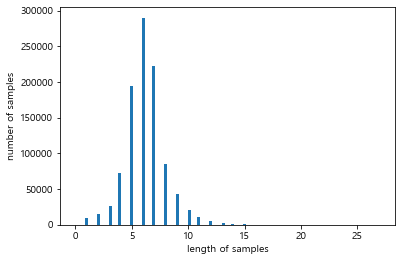

전체 샘플 중 길이가 10 이하인 샘플의 비율: 97.9842


In [57]:
# max_len 결정

print('리뷰의 최대 길이 :',max(len(word) for word in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))

plt.hist([len(word) for word in X_train], bins=100)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))
    
max_len = 10
below_threshold_len(max_len, X_train)

In [59]:
# max_len 에 맞게 데이터셋 패딩

X_train = pad_sequences(X_train, maxlen=max_len)

In [60]:
max_len = 10
X_test = pad_sequences(X_test, maxlen=max_len)

In [61]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size= 0.2)

In [62]:
# 데이터 셋 저장

pd.DataFrame(X_train).to_csv('./data/mecab/X_train.csv', encoding='CP949', index=False)
pd.DataFrame(X_valid).to_csv('./data/mecab/X_valid.csv', encoding='CP949', index=False)
pd.DataFrame(X_test).to_csv('./data/mecab/X_test.csv', encoding='CP949', index=False)
y_train.to_csv('./data/mecab/y_train.csv', encoding='CP949', index=False)
y_valid.to_csv('./data/mecab/y_valid.csv', encoding='CP949', index=False)

print(len(X_train), len(X_valid), len(y_train), len(y_valid), len(X_test))

800000 200000 800000 200000 100000
